In [62]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import quantile_transform
import random

random.seed(42)



# normalizer = Normalizer(norm='l1')
# Load your yearly time series data into a Pandas DataFrame
data = pd.read_csv('/content/merged_data_gdp_final.csv')
# Sort the DataFrame in ascending order in-place
data.sort_values(by='Year', ascending=True, inplace=True)

In [63]:
data.head()

,Year,afghanistan,albania,algeria,andorra,antigua-and-barbuda,argentina,armenia,aruba,australia,...,tonga,trinidad-and-tobago,turkey,tuvalu,uae,uganda,united-kingdom,united-states,uruguay,zimbabwe
0,1991,1.83,1.10,45.72,1.11,0.48,189.72,2.07,0.87,325.99,...,0.13,5.31,150.03,0.01,51.55,3.32,1142.80,6158.13,11.21,8.64
1,1992,1.60,0.65,48.00,1.21,0.50,228.79,1.27,0.96,325.53,...,0.14,5.44,158.46,0.01,54.24,2.86,1179.66,6520.33,12.88,6.75
2,1993,1.73,1.19,49.95,1.01,0.54,236.74,1.20,1.08,312.14,...,0.14,4.67,180.17,0.01,55.63,3.22,1061.39,6858.56,15.00,6.56
3,1994,2.16,1.88,42.54,1.02,0.59,257.44,1.32,1.25,322.81,...,0.20,4.95,130.69,0.01,59.31,3.99,1140.49,7287.24,17.47,6.89
4,1995,2.37,2.39,41.76,1.18,0.58,258.03,1.47,1.32,368.14,...,0.21,5.33,169.49,0.01,65.74,5.76,1346.18,7639.75,19.30,7.11


In [64]:
# data=data.dropna()

In [65]:
# import pandas as pd

# # # Step 2: Save the cleaned DataFrame to a CSV file
# data.to_csv('merged_data_gdp_final.csv', index=False)


In [66]:
# Prepare the data for LSTM input with a custom window size

def create_sequences(data_column, window_length):
    X_sequences = []
    y_sequences = []
    column_data = data_column.to_numpy()

    for i in range(len(column_data) - window_length-1):
        X_sequence = [a for a in column_data[i:i + window_length]]
        y_sequence = column_data[i + window_length]
        X_sequences.append(X_sequence)
        y_sequences.append(y_sequence)

    return np.array(X_sequences), np.array(y_sequences)

In [67]:
# Define the window size for the LSTM model
window_length = 6

# Create input sequences and labels for each column
X_sequences_dict = {}
y_sequences_dict = {}


for column in data.columns[1:]:
    X_column, y_column = create_sequences(data[column], window_length)
    X_sequences_dict[column] = X_column
    y_sequences_dict[column] = y_column


In [68]:
from sklearn import preprocessing

# Assuming you have a 2-dimensional NumPy array
y = np.array(list(y_sequences_dict.values()))
scaler = MinMaxScaler(feature_range=(0.2, 1))

y_normalized = scaler.fit_transform(y)
# # Use the flatten method to create a 1-dimensional array
y_normalized = y_normalized.flatten()

# # Initialize an empty list to store the flattened arrays
flattened_arrays = []

# # Loop through the dictionary and flatten each array based on its key
for key, array in X_sequences_dict.items():

    flattened_array = array.flatten()
    flattened_arrays.append(flattened_array)
    # print(flattened_array)


# # Convert the list of flattened arrays to a 2-dimensional NumPy array
X = np.array(list(X_sequences_dict.values()))
X = np.reshape(X, (-1, window_length))
X_normalized = scaler.fit_transform(X)

In [69]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Set random seed for TensorFlow
tf.random.set_seed(42)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized,
                                                    y_normalized,
                                                    test_size=0.2,
                                                    random_state=42)

In [70]:
# Build the CNN model
from tensorflow.keras.regularizers import l2
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, Flatten,Dropout

random.seed(42)

model = Sequential()

model.add(Conv1D(filters=8,
                 kernel_size=2,
                 activation='relu',
                 input_shape=(window_length,1)))

model.add(MaxPooling1D(pool_size=2))

model.add(Dropout(0.3))

model.add(Conv1D(filters=16,
                 kernel_size=2,
                 activation='relu',
                 ))

model.add(Flatten())

model.add(Dense(10,
                activation='relu',
                kernel_regularizer=l2(0.01)))

model.add(Dense(1,
                activation='linear',
                kernel_regularizer=l2(0.01)))

In [71]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 5, 8)              24        
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 2, 8)             0         
 1D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 2, 8)              0         
                                                                 
 conv1d_9 (Conv1D)           (None, 1, 16)             272       
                                                                 
 flatten_4 (Flatten)         (None, 16)                0         
                                                                 
 dense_8 (Dense)             (None, 10)                170       
                                                      

In [72]:
from keras.callbacks import EarlyStopping
random.seed(42)

model.compile(
    optimizer='adam',
    loss="mse",
    metrics=['accuracy']
)

# simple early stopping
es = EarlyStopping(monitor='val_loss',
                   patience=2)

history = model.fit(
    X_train,
    y_train,
    batch_size=16,
    epochs=100,
    validation_data=(X_test, y_test),
    verbose=0,
    callbacks=[es]
)

In [73]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test,verbose=0)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.0002235420525583187


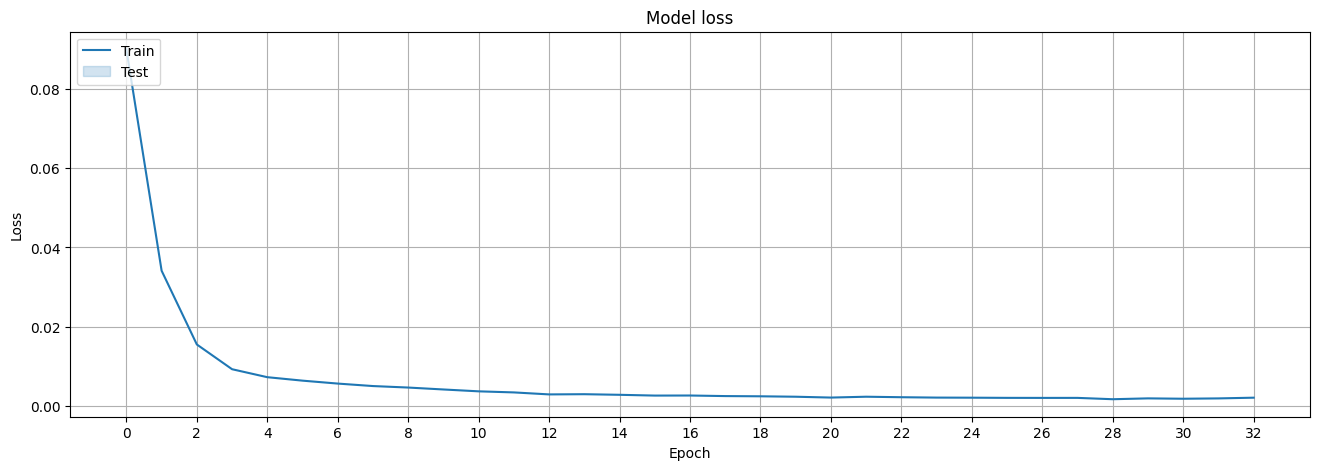

In [74]:
from matplotlib import pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(20))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

# **Multvariant**

In [75]:
correlation_matrix = data.corr()
correlation_matrix

,Year,afghanistan,albania,algeria,andorra,antigua-and-barbuda,argentina,armenia,aruba,australia,...,tonga,trinidad-and-tobago,turkey,tuvalu,uae,uganda,united-kingdom,united-states,uruguay,zimbabwe
Year,1.000000,0.923508,0.967719,0.879295,0.801171,0.959927,0.762660,0.948005,0.959970,0.931312,...,0.952676,0.901488,0.917188,0.961276,0.957844,0.945520,0.913374,0.994840,0.892117,0.797308
afghanistan,0.923508,1.000000,0.907211,0.951374,0.743216,0.866347,0.887527,0.937556,0.861398,0.975732,...,0.968932,0.928543,0.955092,0.915401,0.968064,0.955484,0.835926,0.903684,0.938099,0.801842
albania,0.967719,0.907211,1.000000,0.922999,0.887455,0.954440,0.735761,0.979608,0.945646,0.947679,...,0.943770,0.939998,0.940232,0.945832,0.965357,0.930088,0.937323,0.967630,0.849468,0.746935
algeria,0.879295,0.951374,0.922999,1.000000,0.862608,0.863461,0.830570,0.943963,0.874572,0.972367,...,0.926379,0.984197,0.983704,0.858051,0.967794,0.883251,0.893968,0.861613,0.853621,0.686148
andorra,0.801171,0.743216,0.887455,0.862608,1.000000,0.854775,0.514193,0.848547,0.872203,0.793547,...,0.748472,0.905107,0.875095,0.731206,0.826218,0.693550,0.937642,0.786574,0.573761,0.410909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
uganda,0.945520,0.955484,0.930088,0.883251,0.693550,0.872584,0.854261,0.940650,0.850929,0.955422,...,0.964546,0.865270,0.900280,0.957151,0.947991,1.000000,0.803675,0.943586,0.951296,0.880207
united-kingdom,0.913374,0.835926,0.937323,0.893968,0.937642,0.931912,0.642888,0.910174,0.956897,0.877234,...,0.859116,0.944731,0.928750,0.837620,0.911792,0.803675,1.000000,0.905783,0.728147,0.587358
united-states,0.994840,0.903684,0.967630,0.861613,0.786574,0.962237,0.752046,0.951705,0.951864,0.923849,...,0.948786,0.886351,0.900311,0.968973,0.953311,0.943586,0.905783,1.000000,0.890562,0.817728
uruguay,0.892117,0.938099,0.849468,0.853621,0.573761,0.833019,0.941025,0.889869,0.812140,0.928225,...,0.952976,0.819395,0.865267,0.902061,0.924840,0.951296,0.728147,0.890562,1.000000,0.903938


In [76]:
# Calculate the correlation matrix for the entire dataset
global_correlation_matrix = data.corr()

Top 5 correlated column pairs:
austria    belgium      0.999526
belgium    austria      0.999526
lithuania  estonia      0.998256
estonia    lithuania    0.998256
belgium    denmark      0.997750
denmark    belgium      0.997750
dtype: float64


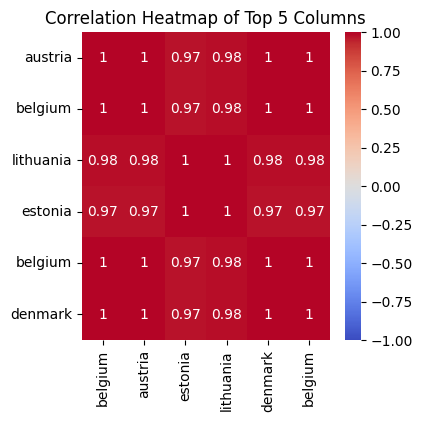

In [77]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

correlation_pairs = correlation_matrix.unstack().sort_values(ascending=False)
top_5_corr_columns = correlation_pairs[correlation_pairs != 1.0][:6]

print("Top 5 correlated column pairs:")
print(top_5_corr_columns)

# We use 'reset_index' to convert the multi-index Series back to a DataFrame.
top_5_corr_matrix = global_correlation_matrix.loc[top_5_corr_columns.index.get_level_values(0),
                                                 top_5_corr_columns.index.get_level_values(1)]


# Step 6: Plot the correlation heatmap using seaborn
plt.figure(figsize=(4, 4))
sns.heatmap(top_5_corr_matrix,
            annot=True,
            cmap='coolwarm',
            center=0,
            vmin=-1,
            vmax=1)

plt.title('Correlation Heatmap of Top 5 Columns')
plt.show()

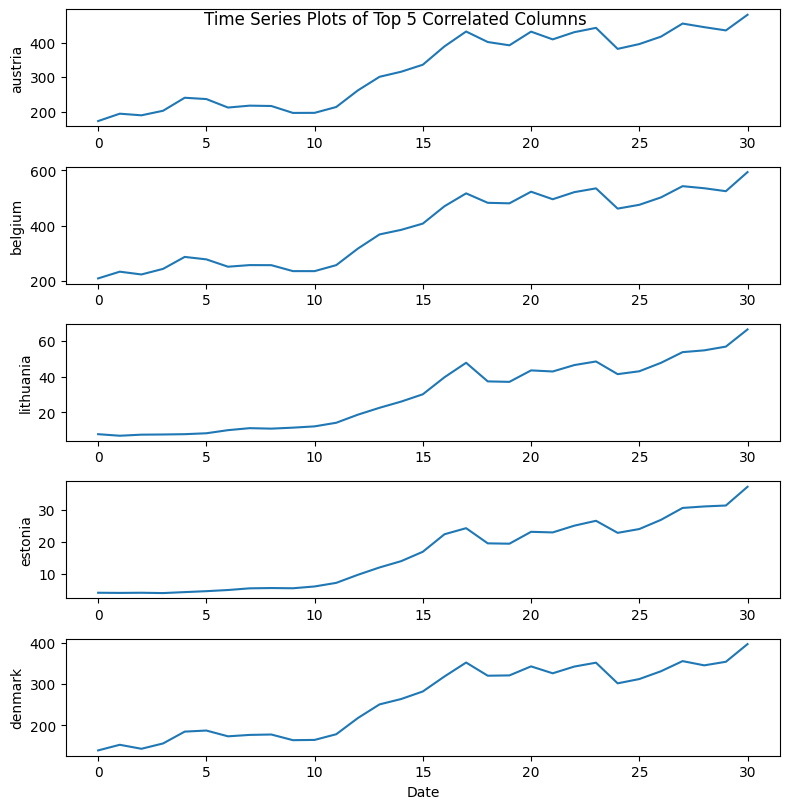

In [78]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Step 5: Get the names of the top 5 correlated columns
top_5_corr_column_names = top_5_corr_columns.index.get_level_values(0).unique()


plt.figure(figsize=(8, 8))
for i, column in enumerate(top_5_corr_column_names, 1):
    plt.subplot(5, 1, i)
    plt.plot(data.index, data[column])
    plt.ylabel(column)
    plt.tight_layout()

plt.xlabel('Date')
plt.suptitle('Time Series Plots of Top 5 Correlated Columns')
plt.show()

In [79]:
# Filter the original DataFrame to include only data from the top 5 correlated countries
top_5_corr_data = data[top_5_corr_column_names]

In [80]:
top_5_corr_data.columns

Index(['austria', 'belgium', 'lithuania', 'estonia', 'denmark'], dtype='object')

In [81]:
input_cols = ['Year', 'austria', 'belgium', 'lithuania', 'estonia']
output_cols = ['Year', 'denmark']

year = data['Year'].astype(str)
data.set_index('Year', inplace=True)

# Filter the original DataFrame to include only data from the top 5 correlated countries
top_5_corr_data['Year'] = top_5_corr_data.index
top_5_corr_data = data[top_5_corr_column_names]

# Save the filtered data to a new CSV file
top_5_corr_data.to_csv('top_5_correlated_countries_with_year.csv')

df = pd.read_csv('top_5_correlated_countries_with_year.csv')

X = df.drop(columns=['Year','denmark'])
y  = df['denmark']

<ipython-input-81-c2e72d9cd8c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_5_corr_data['Year'] = top_5_corr_data.index


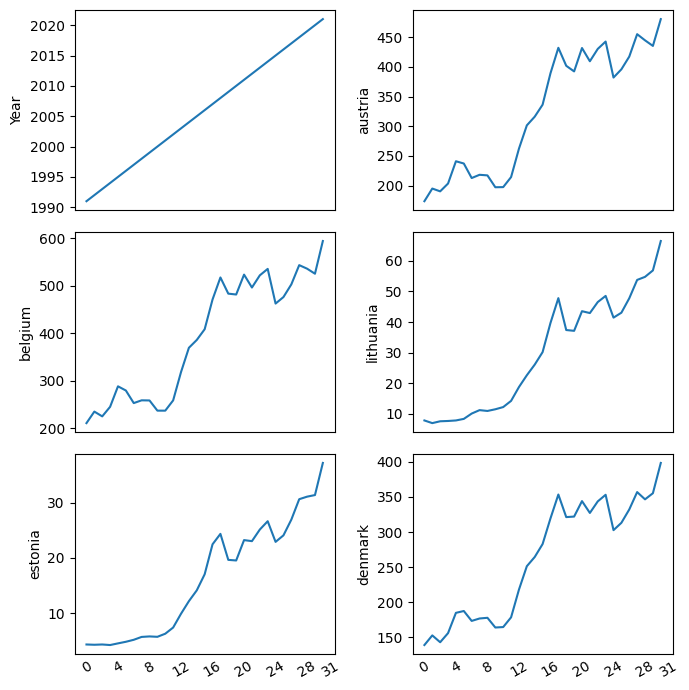

In [82]:
import matplotlib.dates as mdates # Formatting dates
# Plot line charts
df_plot = df.copy()

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(7, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

In [83]:
df.columns

Index(['Year', 'austria', 'belgium', 'lithuania', 'estonia', 'denmark'], dtype='object')

In [84]:
# Prediction Index
index_denmark = data.columns.get_loc("denmark")

In [85]:
# Prepare the data for LSTM input with a custom window size

def create_sequences(data_column, window_length):
    X_sequences = []
    y_sequences = []
    column_data = data_column.to_numpy()

    for i in range(len(column_data) - window_length-1):
        X_sequence = [a for a in column_data[i:i + window_length]]
        y_sequence = column_data[i + window_length]
        X_sequences.append(X_sequence)
        y_sequences.append(y_sequence)

    return np.array(X_sequences), np.array(y_sequences)

In [86]:
# Define the window size for the LSTM model
window_length = 6

# Create input sequences and labels for each column
X_sequences_dict = {}
y_sequences_dict = {}


for column in df.columns[1:]:
    X_column, y_column = create_sequences(df[column], window_length)
    X_sequences_dict[column] = X_column
    y_sequences_dict[column] = y_column


In [87]:
index_denmark

38

In [88]:
from sklearn import preprocessing

# Assuming you have a 2-dimensional NumPy array
y = np.array(list(y_sequences_dict.values()))
scaler = MinMaxScaler(feature_range=(0.2, 1))

y_normalized = scaler.fit_transform(y)
# # Use the flatten method to create a 1-dimensional array
y_normalized = y_normalized.flatten()

# # Initialize an empty list to store the flattened arrays
flattened_arrays = []

# # Loop through the dictionary and flatten each array based on its key
for key, array in X_sequences_dict.items():

    flattened_array = array.flatten()
    flattened_arrays.append(flattened_array)
    # print(flattened_array)


# # Convert the list of flattened arrays to a 2-dimensional NumPy array
X = np.array(list(X_sequences_dict.values()))
X = np.reshape(X, (-1, window_length))
X_normalized = scaler.fit_transform(X)

In [89]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Set random seed for TensorFlow
tf.random.set_seed(42)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized,
                                                    y_normalized,
                                                    test_size=0.2,
                                                    random_state=42)

In [90]:
X_train.shape,y_train.shape

((96, 6), (96,))

In [91]:
# Build the CNN model
from tensorflow.keras.regularizers import l2
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, Flatten,Dropout

random.seed(42)

model = Sequential()

model.add(Conv1D(filters=8,
                 kernel_size=2,
                 activation='relu',
                 input_shape=(window_length,1)))

model.add(MaxPooling1D(pool_size=2))

model.add(Dropout(0.2))

model.add(Conv1D(filters=16,
                 kernel_size=2,
                 activation='relu',
                 ))

model.add(Flatten())

model.add(Dense(10,
                activation='relu',
                kernel_regularizer=l2(0.01)))

model.add(Dense(1,
                activation='linear',
                kernel_regularizer=l2(0.01)))

In [92]:
from keras.callbacks import EarlyStopping
random.seed(42)

model.compile(
    optimizer='adam',
    loss="mse",
    metrics=['accuracy']
)

# simple early stopping
es = EarlyStopping(monitor='val_loss',
                   patience=3)

history = model.fit(
    X_train,
    y_train,
    batch_size=8,
    epochs=100,
    validation_data=(X_test, y_test),
    verbose=0,
    callbacks=[es]
)

In [93]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test,verbose=0)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.011207288760772873


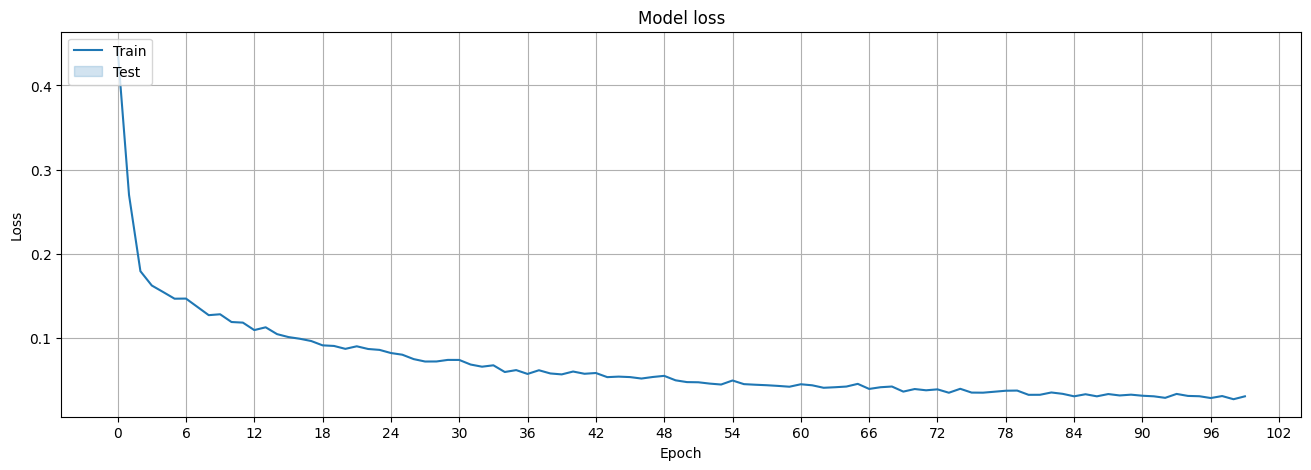

In [94]:
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(20))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

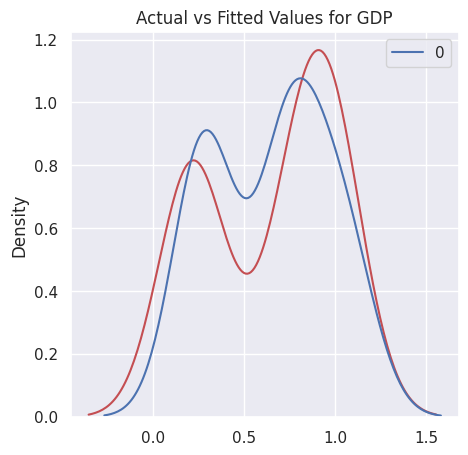

In [95]:
plt.figure(figsize=(5, 5))
import seaborn as sns
sns.set_theme()
df = sns.load_dataset("penguins")

ax1 = sns.kdeplot(y_test,
                   color="r",
                   label="Actual Value")

sns.kdeplot(y_pred,
             color="b",
             label="Fitted Values"
             ,ax=ax1)

plt.title('Actual vs Fitted Values for GDP')

plt.show()
plt.close()

# **Multivariant with pop**

In [4]:
import pandas as pd

# Function to rename columns and add 'GDP' at the end
def rename_columns_with_gdp(column_name):
    if column_name != 'Year':
        return column_name + '_GDP'
    else:
        return column_name

data_gdp = pd.read_csv('/content/merged_data_gdp_final.csv')
# Sort the DataFrame in ascending order in-place
data_gdp.sort_values(by='Year', ascending=True, inplace=True)
# Rename the columns
data_gdp.rename(columns=rename_columns_with_gdp, inplace=True)

In [5]:
data_gdp

,Year,afghanistan_GDP,albania_GDP,algeria_GDP,andorra_GDP,antigua-and-barbuda_GDP,argentina_GDP,armenia_GDP,aruba_GDP,australia_GDP,...,tonga_GDP,trinidad-and-tobago_GDP,turkey_GDP,tuvalu_GDP,uae_GDP,uganda_GDP,united-kingdom_GDP,united-states_GDP,uruguay_GDP,zimbabwe_GDP
0,1991,1.83,1.10,45.72,1.11,0.48,189.72,2.07,0.87,325.99,...,0.13,5.31,150.03,0.01,51.55,3.32,1142.80,6158.13,11.21,8.64
1,1992,1.60,0.65,48.00,1.21,0.50,228.79,1.27,0.96,325.53,...,0.14,5.44,158.46,0.01,54.24,2.86,1179.66,6520.33,12.88,6.75
2,1993,1.73,1.19,49.95,1.01,0.54,236.74,1.20,1.08,312.14,...,0.14,4.67,180.17,0.01,55.63,3.22,1061.39,6858.56,15.00,6.56
3,1994,2.16,1.88,42.54,1.02,0.59,257.44,1.32,1.25,322.81,...,0.20,4.95,130.69,0.01,59.31,3.99,1140.49,7287.24,17.47,6.89
4,1995,2.37,2.39,41.76,1.18,0.58,258.03,1.47,1.32,368.14,...,0.21,5.33,169.49,0.01,65.74,5.76,1346.18,7639.75,19.30,7.11
5,1996,2.56,3.20,46.94,1.22,0.63,272.15,1.60,1.38,401.31,...,0.22,5.76,181.48,0.01,73.57,6.04,1421.62,8073.12,20.52,8.55
6,1997,2.95,2.26,48.18,1.18,0.68,292.86,1.64,1.53,435.61,...,0.21,5.74,189.83,0.01,78.84,6.27,1561.81,8577.55,23.97,8.53
7,1998,3.30,2.55,48.19,1.21,0.73,298.95,1.89,1.67,399.66,...,0.19,6.04,275.97,0.01,75.67,6.58,1655.06,9062.82,25.39,6.40
8,1999,3.70,3.21,48.64,1.24,0.77,283.52,1.85,1.72,389.39,...,0.20,6.81,256.39,0.01,84.45,6.00,1689.29,9631.17,23.98,6.86
9,2000,3.64,3.48,54.79,1.43,0.83,284.20,1.91,1.87,415.85,...,0.20,8.15,274.30,0.02,104.34,6.19,1666.13,10250.95,22.82,6.69


In [11]:
data_pop = pd.read_csv('/content/merged_data_pop.csv')
# Sort the DataFrame in ascending order in-place
data_pop.sort_values(by='Year', ascending=True, inplace=True)

# Function to rename columns and add 'GDP' at the end
def rename_columns_with_POP(column_name):
    if column_name != 'Year':
        return column_name + '_POP'
    else:
        return column_name

# Rename the columns
data_pop.rename(columns=rename_columns_with_POP, inplace=True)

In [13]:
# Perform the merge using the common key/column
merged_df = pd.merge(data_gdp, data_pop, on='Year')
# Save the merged DataFrame to a new CSV file
merged_df.to_csv('merged_file.csv', index=False)

In [14]:
merged_df

,Year,afghanistan_GDP,albania_GDP,algeria_GDP,andorra_GDP,antigua-and-barbuda_GDP,argentina_GDP,armenia_GDP,aruba_GDP,australia_GDP,...,turks-and-caicos-islands_POP,tuvalu_POP,uae_POP,uganda_POP,united-kingdom_POP,united-states_POP,uruguay_POP,venezuela_POP,yemen_POP,zimbabwe_POP
0,1991,1.83,1.10,45.72,1.11,0.48,189.72,2.07,0.87,325.99,...,12329,9354,2008383,18171935,57359454,251560189,3135374,20226214,13895851,10377815
1,1992,1.60,0.65,48.00,1.21,0.50,228.79,1.27,0.96,325.53,...,13014,9466,2116231,18801966,57509240,255175339,3153732,20700461,14433771,10641501
2,1993,1.73,1.19,49.95,1.01,0.54,236.74,1.20,1.08,312.14,...,13704,9517,2223284,19462958,57647463,258779753,3171747,21172100,14988047,10794918
3,1994,2.16,1.88,42.54,1.02,0.59,257.44,1.32,1.25,322.81,...,14402,9559,2329024,20125021,57785900,262273589,3189945,21640833,15553171,10858594
4,1995,2.37,2.39,41.76,1.18,0.58,258.03,1.47,1.32,368.14,...,15101,9585,2433988,20680831,57930364,265660556,3208300,22107286,16103339,10994041
5,1996,2.56,3.20,46.94,1.22,0.63,272.15,1.60,1.38,401.31,...,15806,9611,2572735,21249572,58078586,268984347,3226633,22572110,16614326,11178171
6,1997,2.95,2.26,48.18,1.18,0.68,292.86,1.64,1.53,435.61,...,16515,9630,2746119,21876935,58250198,272395438,3245069,23037561,17108681,11362401
7,1998,3.30,2.55,48.19,1.21,0.73,298.95,1.89,1.67,399.66,...,17239,9634,2921130,22537658,58438321,275835018,3262683,23503819,17608133,11548364
8,1999,3.70,3.21,48.64,1.24,0.77,283.52,1.85,1.72,389.39,...,17984,9640,3097563,23279247,58635202,279181581,3278963,23966960,18114552,11716454
9,2000,3.64,3.48,54.79,1.43,0.83,284.20,1.91,1.87,415.85,...,18744,9638,3275333,24020697,58850043,282398554,3292224,24427729,18628700,11834676


Top 5 correlated column pairs:
comoros_POP       ethiopia_POP        0.999943
ethiopia_POP      comoros_POP         0.999943
Year              haiti_POP           0.999936
haiti_POP         Year                0.999936
burkina-faso_POP  chad_POP            0.999930
chad_POP          burkina-faso_POP    0.999930
dtype: float64


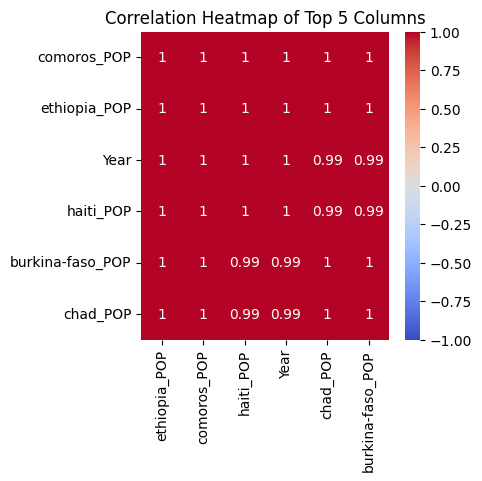

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = merged_df.corr()

# Calculate the correlation matrix for the entire dataset
global_correlation_matrix = merged_df.corr()
correlation_pairs = correlation_matrix.unstack().sort_values(ascending=False)
top_5_corr_columns = correlation_pairs[correlation_pairs != 1.0][:6]

print("Top 5 correlated column pairs:")
print(top_5_corr_columns)

# We use 'reset_index' to convert the multi-index Series back to a DataFrame.
top_5_corr_matrix = global_correlation_matrix.loc[top_5_corr_columns.index.get_level_values(0),
                                                 top_5_corr_columns.index.get_level_values(1)]


# Step 6: Plot the correlation heatmap using seaborn
plt.figure(figsize=(4, 4))
sns.heatmap(top_5_corr_matrix,
            annot=True,
            cmap='coolwarm',
            center=0,
            vmin=-1,
            vmax=1)

plt.title('Correlation Heatmap of Top 5 Columns')
plt.show()

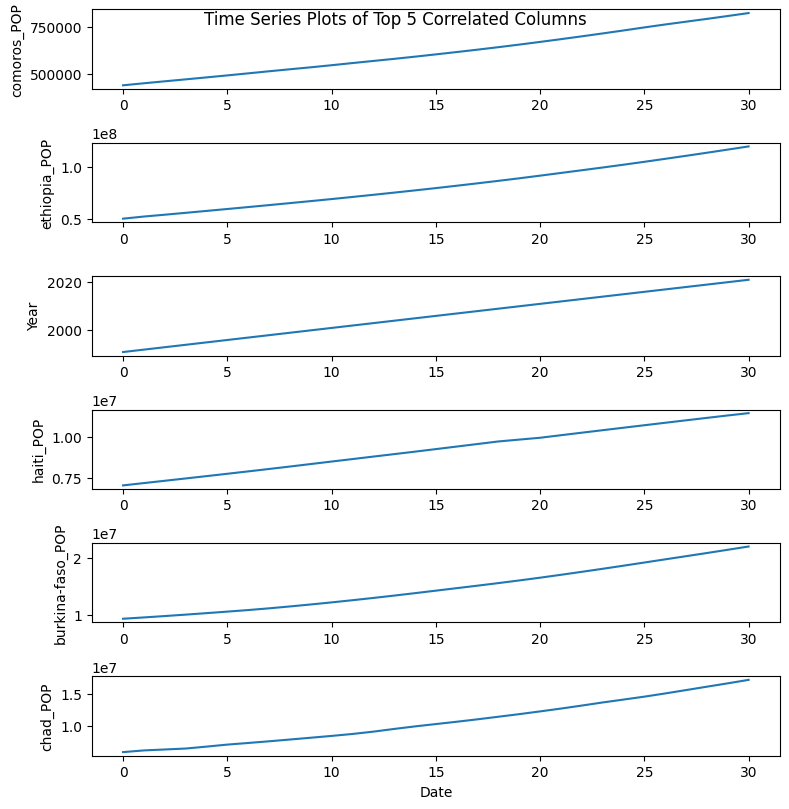

In [20]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Step 5: Get the names of the top 5 correlated columns
top_5_corr_column_names = top_5_corr_columns.index.get_level_values(0).unique()


plt.figure(figsize=(8, 8))
for i, column in enumerate(top_5_corr_column_names, 1):
    plt.subplot(6, 1, i)
    plt.plot(merged_df.index, merged_df[column])
    plt.ylabel(column)
    plt.tight_layout()

plt.xlabel('Date')
plt.suptitle('Time Series Plots of Top 5 Correlated Columns')
plt.show()